In [1]:
from config import settings
from pathlib import Path 

In [2]:
len(list((Path(settings.path.raw)/'2020'/'08').iterdir()))

4452

In [3]:
import h5py
from pathlib import Path
from config import settings

# Define the path to the .mat file
file_path = Path(settings.path.raw) / '2020' / '08' / 'SHMTS_202008111416.mat'

# Open the file and explore the structure
with h5py.File(file_path, 'r') as f:
    f.visititems(lambda name, obj: print(name, obj))


#refs# <HDF5 group "/#refs#" (54 members)>
#refs#/1 <HDF5 dataset "1": shape (2,), type "<u8">
#refs#/2 <HDF5 group "/#refs#/2" (3 members)>
#refs#/2/fmt <HDF5 dataset "fmt": shape (2,), type "<u8">
#refs#/2/isDateOnly <HDF5 dataset "isDateOnly": shape (1, 1), type "|u1">
#refs#/2/tz <HDF5 dataset "tz": shape (2,), type "<u8">
#refs#/A <HDF5 dataset "A": shape (1, 1), type "<u2">
#refs#/B <HDF5 dataset "B": shape (1, 1), type "<u2">
#refs#/C <HDF5 dataset "C": shape (1, 1), type "<u2">
#refs#/D <HDF5 dataset "D": shape (1, 1), type "<u2">
#refs#/E <HDF5 dataset "E": shape (1, 1), type "<u2">
#refs#/F <HDF5 dataset "F": shape (1, 1), type "<u2">
#refs#/G <HDF5 dataset "G": shape (1, 1), type "<u2">
#refs#/H <HDF5 dataset "H": shape (1, 1), type "<u2">
#refs#/I <HDF5 dataset "I": shape (1, 1), type "<u2">
#refs#/J <HDF5 dataset "J": shape (1, 1), type "<u2">
#refs#/K <HDF5 dataset "K": shape (1, 1), type "<u2">
#refs#/L <HDF5 dataset "L": shape (1, 1), type "<u2">
#refs#/M <HDF5 dataset 

In [4]:
import datetime

In [5]:

def extract_references(dataset, file):
    """Extract referenced objects from the HDF5 dataset."""
    decoded_strings = []
    for ref in dataset:
        deref_obj = file[ref[0]]  # Dereference the object reference
        # Decode string if it's a byte array
        if isinstance(deref_obj, h5py.Dataset):
            decoded_strings.append(deref_obj[()].tobytes().decode('utf-16'))  # Decode as UTF-16 here
    return decoded_strings

# Clean up channel names by decoding UTF-16 and removing null characters
def clean_channel_name(name):
    return name.replace('\x00', '')  # Remove null characters
def get_date(file_path):
    """Extract the date from the file path."""
    file_name = file_path.stem.split('_')[-1]
    date = datetime.datetime.strptime(file_name, '%Y%m%d%H%M')
    return date 
def read_mat(file_path):
    """Read the .mat file and extract relevant information."""
    date = get_date(file_path)
    with h5py.File(file_path, 'r') as f:
        # Extract the channel names
        dat = f['Dat']
        channel_names = extract_references(dat['ChannelNames'], f)
        channel_names = [clean_channel_name(name) for name in channel_names]
        
        data  = dat['Data'][()]
        fs = dat['Fs'][0][0]
        channel_units = extract_references(dat['ChannelUnits'], f)
        channel_units = [clean_channel_name(unit) for unit in channel_units]
        
    return {'data': data, 'fs': float(fs), 'channel_names': channel_names, 'channel_units': channel_units, 'date': date}    
        

In [6]:
import h5py
from pathlib import Path
from config import settings
from scipy.signal import welch
import matplotlib.pyplot as plt
import datetime

# Define the path to the .mat file
file_path = Path(settings.path.raw) / '2020' / '08' / 'SHMTS_202008111416.mat'
# weird data ['2020-08-01 00:02:00'] 
file_path_w = Path(settings.path.raw) / '2020' / '08' / 'SHMTS_202008010002.mat'
data_dict  = read_mat(file_path)
data_dict_w  = read_mat(file_path_w)
data = data_dict['data']
data_w = data_dict_w['data']

In [7]:
import torch 
from torchaudio.transforms import Spectrogram

class Welch(torch.nn.Module):
    def __init__(self, fs, nperseg,fmax=None):
        super(Welch, self).__init__()
        self.fs = fs
        self.nperseg = nperseg
        self.fmax = fmax
        self.freq_line = torch.linspace(0., self.fs/2, self.nperseg//2+1)
        if self.fmax is None:
            self.freq_mask = torch.ones_like(self.freq_line, dtype=torch.bool)
        else:
            self.freq_mask = self.freq_line <= self.fmax
        self.freq_line_masked = self.freq_line[self.freq_mask]
        self.spectrogram = Spectrogram(n_fft=self.nperseg)
        
    def forward(self, x):
        if x.dim() == 1:
            x = x.unsqueeze(0)
        spectrogram_data = self.spectrogram(x) /(self.fs)**2
        psd = spectrogram_data.mean(-1)
        psd = psd[..., self.freq_mask]
        return psd
        

In [8]:
fs = 1651

In [9]:
data_dict_w['channel_names']

['accel01x',
 'accel01y',
 'accel02x',
 'accel02y',
 'accel03x',
 'accel03y',
 'accel04x',
 'accel04y',
 'accel05x',
 'accel05y',
 'accel06x',
 'accel06y',
 'accel07x',
 'accel07y',
 'accel08x',
 'accel08y',
 'accel09x',
 'accel09y',
 'strain01',
 'strain02',
 'strain03',
 'temp01']

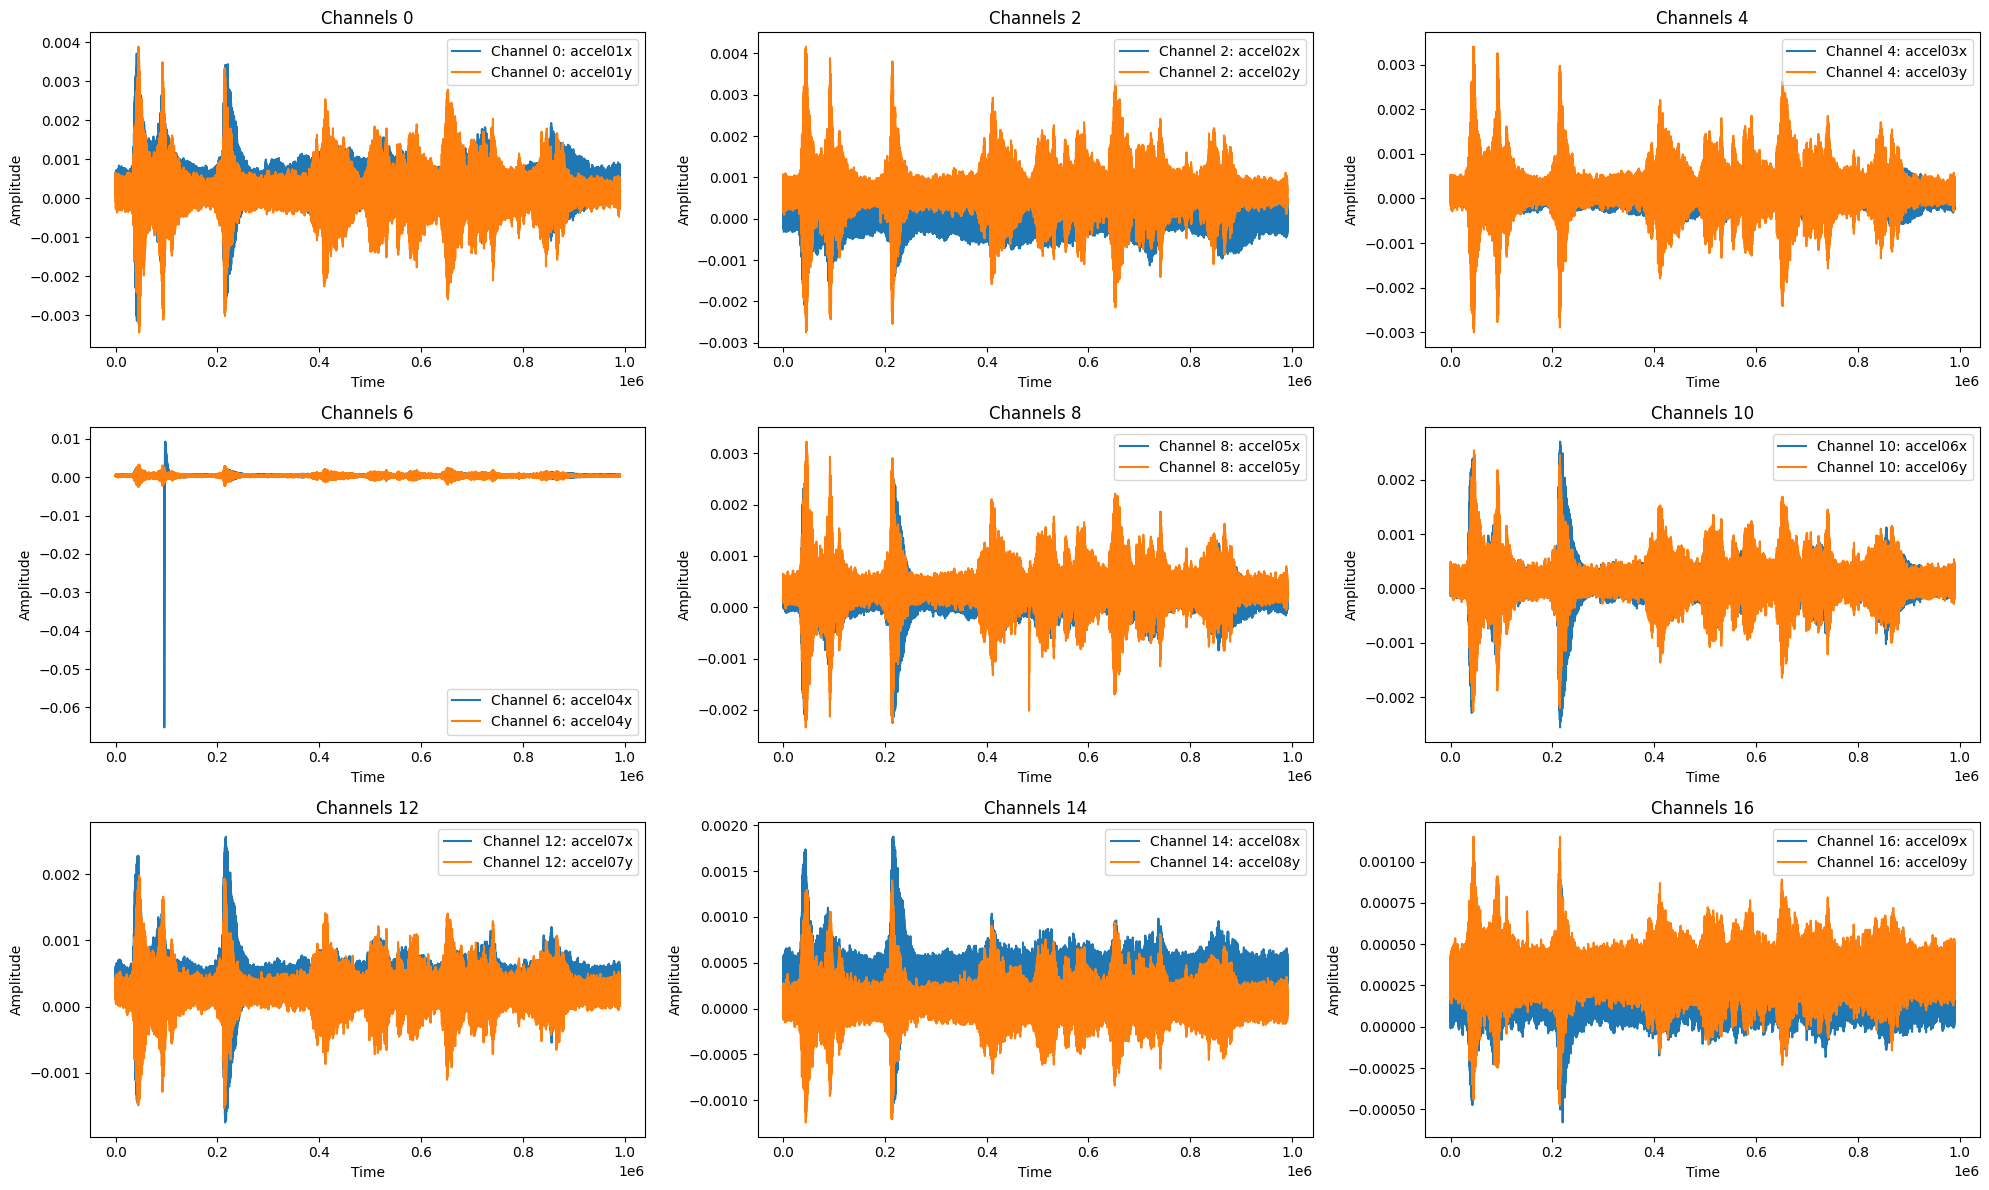

In [10]:
import matplotlib.pyplot as plt

# Create subplots
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(20, 12))
ax = ax.flatten()  # Flatten for easy iteration

# Iterate and plot in pairs (0 and 1, 2 and 3, ...)
for i in range(0, 18, 2):
    idx = i // 2  # Index for the subplot array
    ax[idx].plot(data_dict_w['data'][i], label=f"Channel {i}: {data_dict_w['channel_names'][i]}")
    ax[idx].plot(data_dict_w['data'][i + 1], label=f"Channel {i}: {data_dict_w['channel_names'][i+1]}")
    
    ax[idx].set_title(f"Channels {i}")
    ax[idx].set_xlabel("Time")
    ax[idx].set_ylabel("Amplitude")
    ax[idx].legend()

plt.tight_layout()
plt.show()


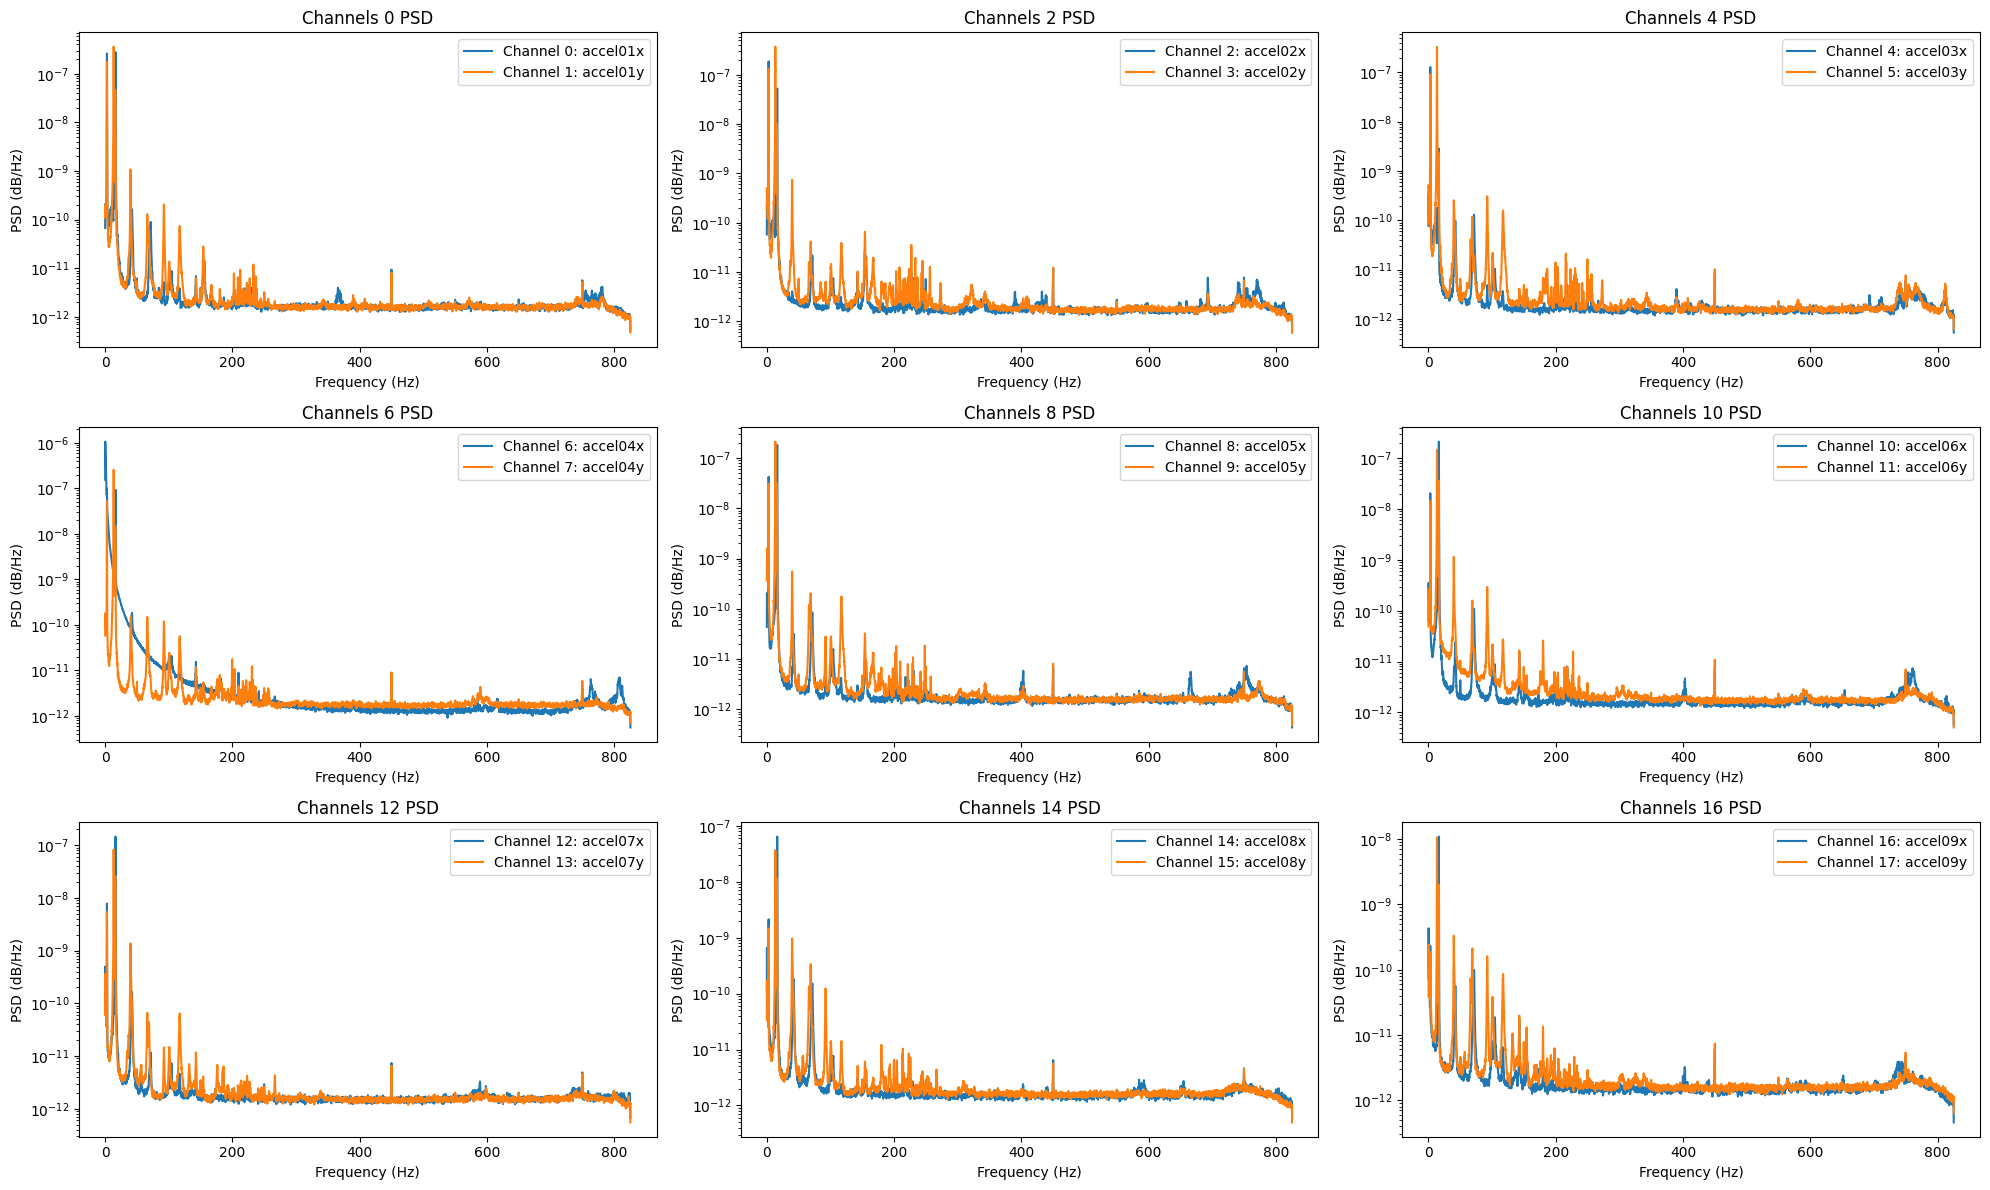

In [11]:
import matplotlib.pyplot as plt
from scipy.signal import welch

# Sampling frequency (adjust as needed)
fs = 1651

# Create subplots
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(20, 12))
ax = ax.flatten()  # Flatten for easy iteration

# Iterate and plot PSD in pairs (0 and 1, 2 and 3, ...)
for i in range(0, 18, 2):
    idx = i // 2  # Index for the subplot array
    
    # Compute PSD for both channels
    f1, Pxx1 = welch(data_dict_w['data'][i], fs=fs, nperseg=8192)
    f2, Pxx2 = welch(data_dict_w['data'][i + 1], fs=fs, nperseg=8192)
    
    # Plot PSD for both channels on the same axis
    ax[idx].semilogy(f1, Pxx1, label=f"Channel {i}: {data_dict_w['channel_names'][i]}")
    ax[idx].semilogy(f2, Pxx2, label=f"Channel {i+1}: {data_dict_w['channel_names'][i+1]}")
    
    ax[idx].set_title(f"Channels {i} PSD")
    ax[idx].set_xlabel("Frequency (Hz)")
    ax[idx].set_ylabel("PSD (dB/Hz)")
    ax[idx].legend()

plt.tight_layout()
plt.show()


In [12]:
len(Pxx1)

4097

time took to compute welch 0.02254343032836914
time took to compute welch using mean 0.010019302368164062


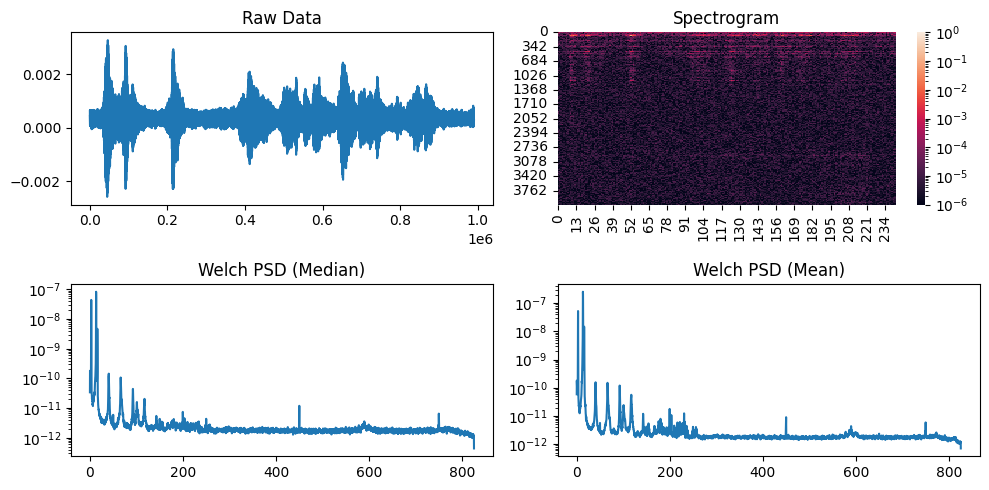

In [13]:
import seaborn as sns
from matplotlib import colors
import matplotlib.pyplot as plt
import torch
from torchaudio.transforms import Spectrogram
from scipy.signal import welch
import time

# Create subplots
fig, ax = plt.subplots(2, 2, figsize=(10, 5))

# Plot raw data
ax[0, 0].plot(data_w[7])
ax[0, 0].set_title("Raw Data")

# Generate and plot spectrogram
spectrogram = Spectrogram(n_fft=8192)(torch.tensor(data_w[7]).unsqueeze(0))
sns.heatmap(spectrogram[0].numpy(), norm=colors.LogNorm(vmin=1e-6, vmax=1), ax=ax[0, 1])
ax[0, 1].set_title("Spectrogram")

# Compute and plot Welch power spectral density (median)
start = time.time()
f, Pxx_median = welch(data_w[7], fs=fs, nperseg=8192, average='median')
print('time took to compute welch', time.time()-start)

ax[1, 0].semilogy(f, Pxx_median)
ax[1, 0].set_title("Welch PSD (Median)")

# Compute and plot Welch power spectral density (mean)
start = time.time() 

f, Pxx_mean = welch(data_w[7], fs=fs, nperseg=8192, average='mean')
print('time took to compute welch using mean', time.time()-start)

ax[1, 1].semilogy(f, Pxx_mean)
ax[1, 1].set_title("Welch PSD (Mean)")

# Show plots
plt.tight_layout()
plt.show()


In [14]:
ax[1,0].semilogy(f, Pxx)


NameError: name 'Pxx' is not defined

 ...]

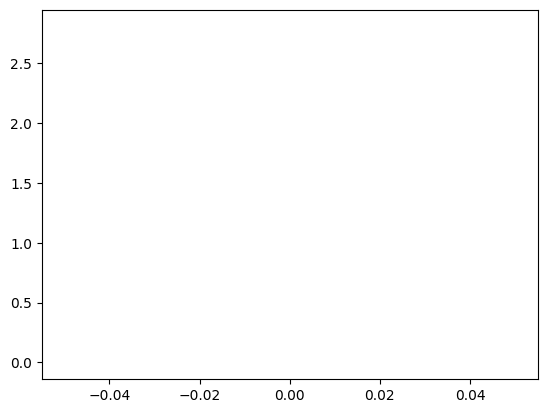

In [ ]:
plt.plot(welch_median.numpy())

0.00961756706237793
0.021464824676513672


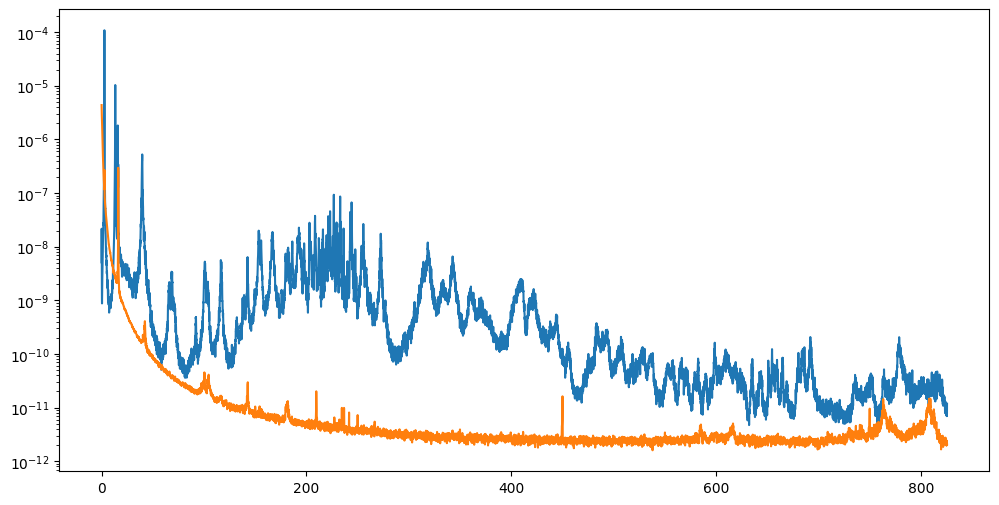

In [ ]:
from scipy.signal import welch 
from time import time

welch_torch = Welch(fs=fs, nperseg=8196*2)
#
ts = time()
psd = welch_torch(torch.tensor(data_w[6]))
print(time()-ts)
ts = time()
f, Pxx = welch(data[3], fs=fs, nperseg=fs*15) 
print(time()-ts)

plt.figure(figsize=(12, 6))
plt.plot(f, Pxx)
plt.plot(welch_torch.freq_line_masked, psd[0])
plt.yscale('log')


In [15]:
file_meta_met = Path(settings.path.raw) / '2021'/'07'/'SHMTS_202107_meta_met.mat'
file_meta_struc = Path(settings.path.raw) / '2021'/'07'/'SHMTS_202107_meta_struct.mat'
file_listofcorrupted = Path(settings.path.raw) / '2021'/'01'/'listOfCorruptedFiles.mat'
example_of_corrupted = Path(settings.path.raw) / '2021'/'01'/'SHMTS_202101301814.mat'

file_meta_met.exists(), file_meta_struc.exists(), file_listofcorrupted.exists(), example_of_corrupted.exists()


(True, True, True, True)

In [16]:
def identify_file(path:Path| str):
    if isinstance(path, str):
        path = Path(path)
    if 'meta_met' in path.stem:
        return 'meta_met'
    elif 'meta_struct' in path.stem:
        return 'meta_struct'
    elif 'listOfCorruptedFiles' in path.stem:
        return 'corrupted_files'
    elif len(path.stem.split('_')[1]) == 12:
        return 'acceleration'
    else:   
        raise ValueError(f'Unknown file type for {path.stem}')

In [17]:
identify_file(file_meta_met), identify_file(file_meta_struc), identify_file(file_listofcorrupted), identify_file(file_path)

('meta_met', 'meta_struct', 'corrupted_files', 'acceleration')

In [18]:
from hannover_pylon.data import utils


/home/owilab/Documents/YacineB/Code/hannover-pylon/.venv/lib/python3.10/site-packages/torchdata/datapipes/__init__.py:18: UserWarning: 
################################################################################
WARNING!
The 'datapipes', 'dataloader2' modules are deprecated and will be removed in a
future torchdata release! Please see https://github.com/pytorch/data/issues/1196
to learn more and leave feedback.
################################################################################

  deprecation_warning()


In [19]:
from scipy.io import loadmat
loadmat(file_listofcorrupted)

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Thu Dec  2 10:10:13 2021',
 '__version__': '1.0',
 '__globals__': [],
 'listOfCorruptedFiles': array([[array(['SHMTS_202101290205.mat'], dtype='<U22')],
        [array(['SHMTS_202101301814.mat'], dtype='<U22')],
        [array(['SHMTS_202101301844.mat'], dtype='<U22')],
        [array(['SHMTS_202101301914.mat'], dtype='<U22')],
        [array(['SHMTS_202101310234.mat'], dtype='<U22')],
        [array(['SHMTS_202101310534.mat'], dtype='<U22')],
        [array(['SHMTS_202101310634.mat'], dtype='<U22')],
        [array(['SHMTS_202101310744.mat'], dtype='<U22')],
        [array(['SHMTS_202101310854.mat'], dtype='<U22')],
        [array(['SHMTS_202101310914.mat'], dtype='<U22')],
        [array(['SHMTS_202101311124.mat'], dtype='<U22')],
        [array(['SHMTS_202101311144.mat'], dtype='<U22')],
        [array(['SHMTS_202101311234.mat'], dtype='<U22')],
        [array(['SHMTS_202101311434.mat'], dtype='<U22')],
        [ar

In [20]:
%load_ext autoreload
%autoreload 2

In [21]:
utils.read_mat(file_meta_struc)['data'].shape

(66, 4463)

In [22]:
utils.read_mat(file_meta_struc)['data'].shape

(66, 4463)

In [23]:
len(file_path.stem.split('_')[1])

12

In [24]:
get_date(file_path)

datetime.datetime(2020, 8, 11, 14, 16)

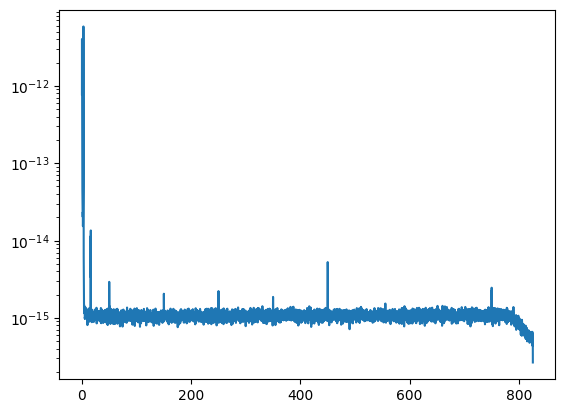

In [25]:
f,p = welch(utils.read_mat(file_path)['data'][20],fs = 1651, nperseg=8196*2)
plt.plot(f,p.T)
plt.yscale('log')

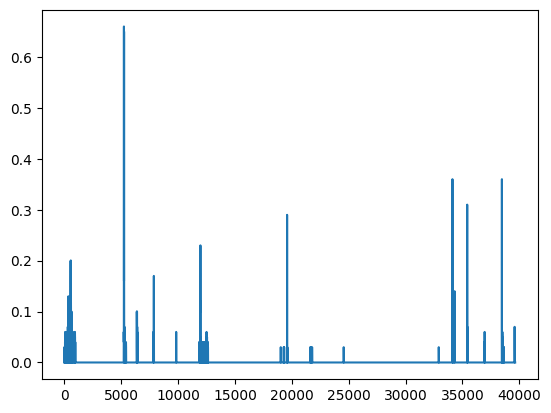

In [26]:
plt.plot(utils.read_mat(file_meta_met)['data'][2])